In [57]:
import numpy as np
import pandas as pd
import pandana as pdna
import geopandas as gp
import matplotlib.pyplot as plt
%matplotlib inline
# import folium

ModuleNotFoundError: No module named 'folium'

In [34]:
homedata_file_path = '/home/data/'
dd = '/home/data/spring_2019/base/'
shapefiles_path = '/home/simon/spatial-data/'
model_outputs_path = '/home/data/spring_2019/'

In [35]:
#read in model data output from 2040
# store = pd.HDFStore(model_outputs_path+'outputs/model_data_output_2040.h5') #sometimes doesnt work with a relative file path
# store.keys()


In [36]:
def compare(table, column):
    return len(table[column].unique())

In [37]:
# ! ls /home/data/spring_2019/base/

baseline-calibration-smart-rw-52-20.skimsExcerpt.csv
baseline-calibration-smart-rw-55-20.skimsExcerpt.csv
baus_model_data.h5
bay_area_tertiary_strongly_edges.csv
bay_area_tertiary_strongly_nodes.csv
bayarea_walk_edges.csv
bayarea_walk_nodes.csv
buildings_v2.csv
drive_net_vars.csv
establishments_v2.csv
households_v2.csv
jobs_v2.csv
model_data.h5
MTC_craigslist_listings_7-10-18.csv
parcel_attr.csv
persons_v3.csv
run44-30.skimsExcerpt.csv
sfbay-smart-base__2019-03-28_14-22-12
skims_110118.csv
smart-baseline-calibration-rw-55.tar.gz
units_v2.csv
walk_net_vars.csv
zones.csv


In [38]:
# buildings = pd.read_csv(dd + "buildings_v2.csv", nrows=100000)
persons = pd.read_csv(dd + "persons_v3.csv") #add nrows when testing
parcels = pd.read_csv(dd + "parcel_attr.csv")
buildings = pd.read_csv(dd + "buildings_v2.csv")
households = pd.read_csv(dd + "households_v2.csv")


,person_id,member_id,age,primary_commute_mode,relate,edu,sex,hours,hispanic,earning,race_id,student,work_at_home,worker,household_id
0,0,1,47,1.0,0,22.0,1,40.0,1,85000.0,1,0,0,1,0
1,1,1,47,1.0,0,22.0,1,40.0,1,85000.0,1,0,0,1,670
2,2,1,47,1.0,0,22.0,1,40.0,1,85000.0,1,0,0,1,740
3,3,1,47,1.0,0,22.0,1,40.0,1,85000.0,1,0,0,1,975
4,4,1,47,1.0,0,22.0,1,40.0,1,85000.0,1,0,0,1,977


In [39]:
per_house = pd.merge(persons, households, on='household_id', how='inner') #97139 inner merge, 100000 left merge, 15843 unique building ids in this subset
house_build = pd.merge(per_house, buildings, on='building_id', how='inner') #just the households with assigned buildings and the buildings with assigned households?
build_parcel = pd.merge(house_build, parcels, left_on='parcel_id',right_on='primary_id', how='inner')


Index(['person_id', 'member_id', 'age', 'primary_commute_mode', 'relate',
       'edu', 'sex', 'hours', 'hispanic', 'earning', 'race_id', 'student',
       'work_at_home', 'worker', 'household_id', 'serialno', 'persons',
       'building_type', 'cars', 'income', 'race_of_head', 'hispanic_head',
       'age_of_head', 'workers', 'state', 'county', 'tract', 'block_group',
       'children', 'tenure', 'recent_mover', 'block_group_id', 'single_family',
       'unit_id', 'building_id', 'parcel_id', 'development_type_id_x',
       'improvement_value', 'residential_units', 'residential_sqft',
       'sqft_per_unit', 'non_residential_sqft', 'building_sqft',
       'nonres_rent_per_sqft', 'res_price_per_sqft', 'stories', 'year_built',
       'redfin_sale_price', 'redfin_sale_year', 'redfin_home_type',
       'costar_property_type', 'costar_rent', 'building_type_id', 'primary_id',
       'development_type_id_y', 'land_value', 'acres', 'county_id', 'zone_id',
       'proportion_undevelopable', 'ta

Get the number of workers for each race by node

In [40]:
def workers_by_race(df):
    nhwhite_workers = sum((df["race_id"] == 1) & (df["hispanic"] == 1) & (df["worker"] == 1))
    nhblack_workers = sum((df["race_id"] == 2) & (df["hispanic"] == 1) & (df["worker"] == 1))
    nhasian_workers = sum((df["race_id"] == 6) & (df["hispanic"] == 1) & (df["worker"] == 1))
    hispanic_workers = sum((df["hispanic"] != 1) & (df["worker"] == 1))
    non_workers_any = sum(df["worker"] == 0)
    block = np.mean(df['block_id']) # i think this is ok for now because they should all be the same
    return [nhwhite_workers, nhblack_workers, nhasian_workers, hispanic_workers, non_workers_any, block]

In [41]:
node_df_lol = []
node_id_list = []
for node_id, node_df in build_parcel.groupby("node_id"):
    node_id_list.append(node_id)
    row = []
    row.extend(workers_by_race(node_df))
    node_df_lol.append(row)
workers_by_node = pd.DataFrame(node_df_lol, columns=["nhwhite_workers", "nhblack_workers","nhasian_workers",
              "hispanic_workers", "non_workers_any", "block_id"], index=node_id_list)


Calculate the jobs accessibility by node (currently this is just using the data that was in the base directory. only for 1 year? could be improved with the data from the bayarea_urbansim model

In [43]:
drive_net_vars_10 = pd.read_csv(model_outputs_path+ '2010/drive_net_vars.csv')
drive_net_vars_25 = pd.read_csv(model_outputs_path+ '2025/drive_net_vars.csv')
# drive_net_vars_30 = pd.read_csv(model_outputs_path+ '2030/drive_net_vars.csv') #this doesnt exist- how can I get it?
# drive_net_vars_40 = pd.read_csv(model_outputs_path+ '2040/drive_net_vars.csv')

In [44]:
drive_net_vars = pd.read_csv(dd + "drive_net_vars.csv") 
workers_drive_vars = pd.merge(drive_net_vars, workers_by_node, left_on="osmid", right_index=True, how='inner')
drive_jobs_vars = workers_drive_vars[['osmid', 'jobs_10000_retail',
       'jobs_25000_retail', 'jobs_10000_fire', 'jobs_25000_fire',
       'jobs_10000_tech', 'jobs_25000_tech', 'jobs_10000_serv',
       'jobs_25000_serv', 'pop_jobs_ratio_10000', 'pop_jobs_ratio_25000',
       'nhwhite_workers', 'nhblack_workers', 'nhasian_workers',
       'hispanic_workers', 'non_workers_any', "block_id"]]
drive_jobs_vars["block_id"] = drive_jobs_vars["block_id"].apply(lambda x: "0" + str(int(x)))
drive_jobs_vars["block_gp_id"] = drive_jobs_vars["block_id"].apply(lambda x: x[:12])
drive_jobs_vars["tract_id"] = drive_jobs_vars["block_id"].apply(lambda x: x[:11])


/home/amelia/enter/envs/template-env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/amelia/enter/envs/template-env/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/home/amelia/enter/envs/template-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

,osmid,jobs_10000_retail,jobs_25000_retail,jobs_10000_fire,jobs_25000_fire,jobs_10000_tech,jobs_25000_tech,jobs_10000_serv,jobs_25000_serv,pop_jobs_ratio_10000,pop_jobs_ratio_25000,nhwhite_workers,nhblack_workers,nhasian_workers,hispanic_workers,non_workers_any,block_id,block_gp_id,tract_id
8860,65450671,36360.0,89793.0,16033.0,38436.0,36273.0,87162.0,21490.0,48812.0,1.925407,2.414146,0,0,0,2,5,060855011022008,060855011022,06085501102
9091,65460559,36378.0,89958.0,16120.0,38700.0,36172.0,87238.0,21697.0,48932.0,1.834364,2.416042,0,0,0,1,1,060855011022000,060855011022,06085501102
10390,65537596,36780.0,89818.0,16350.0,38686.0,36511.0,87216.0,21869.0,48812.0,1.915495,2.412794,1,0,0,2,2,060855011022008,060855011022,06085501102
10310,65529804,35389.0,87363.0,16462.0,36916.0,31862.0,85963.0,21100.0,46747.0,2.154962,2.411662,0,0,2,1,0,060855012003005,060855012003,06085501200
10300,65529254,35711.0,86008.0,16676.0,36602.0,30663.0,85600.0,20739.0,46078.0,2.308879,2.387909,2,1,0,0,0,060855013003010,060855013003,06085501300


In [48]:
block = gp.read_file('/home/simon/spatial-data/tl_2018_06_bg/tl_2018_06_bg.shp')
tracts = gp.read_file(shapefiles_path+'tl_2018_06_tract/tl_2018_06_tract.shp')


In [46]:
drive_jobs_tracts = tracts.merge(drive_jobs_vars, left_on='GEOID', right_on='tract_id', how='right')
drive_jobs_tracts[["geometry", "GEOID", "tract_id"]]

,geometry,GEOID,tract_id
0,"POLYGON ((-121.890451 37.353716, -121.889821 3...",06085501102,06085501102
1,"POLYGON ((-121.890451 37.353716, -121.889821 3...",06085501102,06085501102
2,"POLYGON ((-121.890451 37.353716, -121.889821 3...",06085501102,06085501102
3,"POLYGON ((-121.885665 37.347291, -121.885032 3...",06085501200,06085501200
4,"POLYGON ((-121.881038 37.340693, -121.880827 3...",06085501300,06085501300
5,"POLYGON ((-121.931868 37.319857, -121.931702 3...",06085502002,06085502002
6,"POLYGON ((-121.884891 37.328588, -121.884084 3...",06085501600,06085501600


In [49]:
drive_jobs_blks = block.merge(drive_jobs_vars, left_on='GEOID', right_on='block_gp_id', how='inner')
drive_jobs_blks[["geometry", "GEOID", "block_gp_id"]]

,geometry,GEOID,block_gp_id
0,"POLYGON ((-121.931868 37.319857, -121.931702 3...",060855020023,060855020023
1,"POLYGON ((-121.890451 37.353716, -121.889821 3...",060855011022,060855011022
2,"POLYGON ((-121.890451 37.353716, -121.889821 3...",060855011022,060855011022
3,"POLYGON ((-121.890451 37.353716, -121.889821 3...",060855011022,060855011022
4,"POLYGON ((-121.883011 37.343728, -121.882379 3...",060855012003,060855012003
5,"POLYGON ((-121.878396 37.33753, -121.878039 37...",060855013003,060855013003
6,"POLYGON ((-121.883049 37.326078, -121.882481 3...",060855016005,060855016005


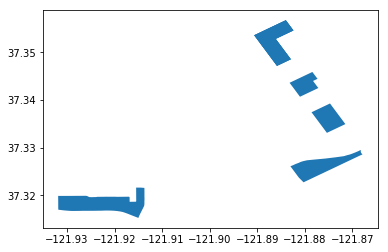

In [53]:
drive_jobs_blks.plot()
plt.savefig('drive_jobs_blks.png')

In [54]:
# m = folium.Map()
# m.choropleth(drive_jobs_blks, data=drive_jobs_blks, key_on='feature.id',
#              columns=['name', 'pop_est'], fill_color='YlOrBr')
# m

NameError: name 'folium' is not defined